In [1]:
import pandas as pd                                     # type: ignore
import numpy as np                                      # type: ignore
import warnings                                         # type: ignore
from sklearn.model_selection import train_test_split    # type: ignore
from sklearn.decomposition import PCA                   # type: ignore
from sklearn.preprocessing import StandardScaler, MinMaxScaler# type: ignore
from sklearn.model_selection import GridSearchCV, KFold # type: ignore
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, precision_recall_curve# type: ignore
import tensorflow as tf                                 # type: ignore
from tensorflow import keras                            # type: ignore
from keras.layers import Dense, Dropout                 # type: ignore
from keras.optimizers import Adam, SGD                  # type: ignore
from keras.callbacks import EarlyStopping               # type: ignore
from kerastuner.tuners import Hyperband                 # type: ignore
from tensorboard.plugins.hparams import api as hp       # type: ignore
import matplotlib.pyplot as plt                         # type: ignore
from imblearn.over_sampling import RandomOverSampler, SMOTE# type: ignore
from imblearn.under_sampling import TomekLinks          # type: ignore
from itertools import combinations_with_replacement
warnings.filterwarnings(action='ignore')

tf.config.set_visible_devices([], 'GPU')

C:\Users\Hi\AppData\Local\Temp\ipykernel_21976\3860009895.py:14: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband                 # type: ignore


In [4]:
# GPU 설정
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print(physical_devices[0])

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [5]:
class DNNModel:
    def __init__(self) -> None:
        self.model = None
        self.df = None
        self.x_train = None
        self.y_train = None
        self.input_dim = 0
        self.model_name = ""

    def load_file(self, file_path:str)->None:
        self.df = pd.read_csv(file_path)
        x_train = self.df.drop(columns=['loan_status', 'Unnamed: 0'])
        # x_train = self.df.drop(columns=['loan_status'])
        
        y_train = self.df['loan_status']
        nan_indices = np.isnan(x_train).any(axis=1)
        self.x_train = x_train[~nan_indices]
        self.y_train = y_train[~nan_indices]
    
    def __get_n_components_from_pca(self, scaled_data:pd.DataFrame, threshold:float) -> int:
        pca = PCA()
        pca.fit(scaled_data)
        explained_variance = pca.explained_variance_ratio_
        cumulative_explained_variance = np.cumsum(explained_variance)
        n_components = np.argmax(cumulative_explained_variance >= threshold) + 1
        return n_components
    
    def scaling_data(
            self, 
            scaler:MinMaxScaler|StandardScaler=StandardScaler, 
            threshold:float=0.95, 
            over_sampler:SMOTE|RandomOverSampler=None, 
            under_sampler:TomekLinks=None)->None:
        x_scaled = scaler().fit_transform(self.x_train)
        self.input_dim = self.__get_n_components_from_pca(x_scaled, threshold=threshold)
        self.model_name+=(f'scaler({scaler.__name__})_pca({(int(threshold*100))})_input({str(self.input_dim)})')
        self.x_train = PCA(n_components=self.input_dim).fit_transform(x_scaled).astype('float32')
        if over_sampler!=None:
            os = over_sampler(random_state=30)
            self.x_train, self.y_train = os.fit_resample(self.x_train,self.y_train)
            self.model_name+=f'_sampler({os.__class__.__name__})'
            print(f"====Data set resampled(oversampled)_{os.__class__.__name__}")
        elif under_sampler!=None:
            us = under_sampler(random_state=30, sampling_strategy='majority')
            self.x_train, self.y_train = us.fit_resample(self.x_train, self.y_train)
            self.model_name+=f'_sampler({us.__class__.__name__})'
            print(f"====Data set resampled(undersampled)_{us.__class__.__name__}")
        print(f"==label ratio")
        print(f"True Label:\t{np.sum(self.y_train==1)/len(self.y_train)}")
        print(f"False Label:\t{np.sum(self.y_train==0)/len(self.y_train)}")
        self.x_train, self.x_validation, self.y_train, self.y_validation = train_test_split(self.x_train, self.y_train, test_size=0.2, stratify=self.y_train, random_state=30)
    
    def __build_model(self, num_layers:int, num_nodes:int, loss:str, num_nodes_per_each_layers:list[int]=None)->keras.Sequential:
        # Define and compile the model
        model = keras.Sequential()
        model.add(Dense(num_nodes, input_dim=self.input_dim, activation='relu'))
        for layer_index in range(num_layers):
            if num_nodes_per_each_layers:
                model.add(Dense(num_nodes_per_each_layers[layer_index], activation='relu'))
            else:
                model.add(Dense(num_nodes, activation='relu'))
            model.add(Dropout(0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='Adam', loss=loss, metrics=["accuracy"])
        return model
    
    def searching_best_param_grid(
            self, 
            grid_params:dict,
            params:dict={'min_delta':0.001, "n_splits":5},
            scoring='accuracy'
            ):
        kfold = KFold(random_state=30,
                n_splits=params['n_splits'],
                shuffle=True
                )
        model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=self.__build_model)
        # GridSearchCV 생성
        grid_search = GridSearchCV(estimator = model,
                                param_grid = grid_params,
                                cv = kfold,
                                scoring=scoring)
        early_stopping = EarlyStopping(monitor='loss',min_delta=params['min_delta'])
        # GridSearchCV fit 시작
        grid_search.fit(self.x_train, self.y_train, callbacks=[early_stopping])
        # 최적의 param
        print(f"Best params: {grid_search.best_params_}")
        # 최적의 param일 경우 최적의 accuracy
        print(f"Best average accuracy: {grid_search.best_score_}")
        return grid_search.best_params_, grid_search.best_score_

    def build_model_with_best_params(
            self, 
            best_params:dict, 
            params:dict={'min_delta':0.001, "n_splits":5}, 
            threshold:float=0.5)->dict:
        valid_accs, valid_f1s, valid_recalls, valid_precisions = [], [], [], []
        result_dict = {
                       'average validation accuracy':0,
                       'average validation recall':0,
                       'average validation precision':0,
                       'average validation f1':0,
                       'validation accuracy':0,
                       'validation recall':0,
                       'validation precision':0,
                       'validation f1':0,
                       }
        y_train_reshaped = np.reshape(self.y_train,(-1))
        model = self.__build_model(best_params['num_layers'], best_params['num_nodes'], best_params['loss'])
        kf = KFold(n_splits=params['n_splits'], shuffle=True, random_state=30)
        early_stopping = EarlyStopping(monitor='loss',min_delta=params['min_delta'])
        for train_index, val_index in kf.split(self.x_train, y_train_reshaped):
            X_train_fold, X_val_fold = self.x_train[train_index], self.x_train[val_index]
            Y_train_fold, Y_val_fold = y_train_reshaped[train_index], y_train_reshaped[val_index]
            # 모델 학습
            model.fit(X_train_fold, 
                    Y_train_fold, 
                    batch_size=best_params['batch_size'], 
                    epochs=best_params['epochs'], 
                    verbose=1,
                    callbacks=[early_stopping])
            # 모델 validation
            valid_loss, valid_acc= model.evaluate(X_val_fold, Y_val_fold)
            pred = model.predict(X_val_fold).flatten()
            pred = np.where(pred >= threshold, 1 , 0)
            valid_accs.append(valid_acc)
            valid_f1s.append(f1_score(Y_val_fold, pred))
            valid_precisions.append(precision_score(Y_val_fold, pred))
            valid_recalls.append(recall_score(Y_val_fold, pred))
        result_dict['average validation accuracy'] = np.mean(valid_accs)
        result_dict['average validation recall'] = np.mean(valid_recalls)
        result_dict['average validation precision'] = np.mean(valid_precisions)
        result_dict['average validation f1'] = np.mean(valid_f1s)
        print("###################################")
        print("avg Validation accuracy:", result_dict['average validation accuracy'])
        print("avg Validation recall:", result_dict['average validation recall'])
        print("avg Validation precision:", result_dict['average validation precision'])
        print("avg Validation F1-score:", result_dict['average validation f1'])

        valid_pred = model.predict(self.x_validation).flatten()
        valid_pred = np.where(valid_pred>=threshold, 1, 0)

        result_dict['validation accuracy'] = accuracy_score(Y_val_fold, pred)
        result_dict['validation f1'] = (f1_score(Y_val_fold, pred))
        result_dict['validation precision'] = (precision_score(Y_val_fold, pred))
        result_dict['validation recall'] = (recall_score(Y_val_fold, pred))
        print("###################################")
        print("Validation accuracy:", result_dict['validation accuracy'])
        print("Validation recall:", result_dict['validation recall'])
        print("Validation precision:", result_dict['validation precision'])
        print("Validation F1-score:", result_dict['validation f1'])
        self.model = model
        return result_dict
    
    def save_model(self, file_path:str="dnn_models/0425/dnn_")->None:
        self.model.save(file_path+self.model_name+'.h5')
 
    def load_model(self, model_file_path:str="dnn_models/0425/dnn_"):
        self.model = tf.keras.models.load_model(model_file_path)

    def get_input_dim(self)->int:
        return self.input_dim

    def get_model(self)->keras.Sequential:
        return self.model

    def get_model_name(self)->str:
        return self.model_name

    def get_roc_auc_score(self, save:bool=True)->float:
        valid_pred = self.model.predict(self.x_validation).flatten()
        fprs, tprs, thresholds = roc_curve(self.y_validation, valid_pred)
        plt.figure(figsize=(10, 5))
        plt.plot(fprs, tprs, label='ROC')
        plt.xlabel("FPR(Fall-Out)")
        plt.ylabel("TPR(Recall):재현률")
        plt.legend()
        plt.show()
        if save:
            plt.savefig(f'plots/{self.model_name}.png')
        return roc_auc_score(self.y_validation, valid_pred)
    
    def draw_precision_recall_curve_plot(self, min_delta:float=0.01, save:bool=True)->float:
        valid_pred = self.model.predict(self.x_validation).flatten()
        precisions, recalls, thresholds = precision_recall_curve(self.y_validation, valid_pred)
        # y축인 precisions와 recalls의 갯수 = threshold 갯수 + 1 이어서 x,y 갯수를 동일하게 맞춰줌
        thres_boundary = thresholds.shape[0]
        plt.plot(thresholds, precisions[:thres_boundary], "r", label="precision")
        plt.plot(thresholds, recalls[:thres_boundary], label="recall")

        # x축 스케일 0.1 단위로 조정
        start, end = plt.xlim()
        plt.xticks( np.round( np.arange(start, end, 0.1), 2))
        # 라벨링
        plt.xlabel("Threshold value"), plt.ylabel("Precision and Recall value")
        plt.legend()
        plt.show()
        if save:
            plt.savefig(f'plots/{self.model_name}_precision&recall.png')
        min_delta_index = None
        for i in range(len(precisions)):
            delta = abs(precisions[i] - recalls[i])
            if delta <= min_delta:
                min_delta_index = i
                break
        return recalls[min_delta_index]
    
    def get_y_train(self)->np.ndarray:
        return self.y_train
    
    def get_y_validation(self)->np.ndarray:
        return self.y_validation

====Data set resampled(oversampled)_SMOTE
==label ratio
True Label:	0.5
False Label:	0.5
Epoch 1/5
11559/11559 [==============================] - 13s 1ms/step - loss: 0.6326 - accuracy: 0.6442
Epoch 2/5
9030/9030 [==============================] - 5s 564us/step
Epoch 1/5
11559/11559 [==============================] - 12s 993us/step - loss: 0.6316 - accuracy: 0.6465
Epoch 2/5
9030/9030 [==============================] - 5s 580us/step
Epoch 1/5
11559/11559 [==============================] - 12s 975us/step - loss: 0.6333 - accuracy: 0.6443
Epoch 2/5
9030/9030 [==============================] - 5s 581us/step
Epoch 1/5
11559/11559 [==============================] - 12s 996us/step - loss: 0.6347 - accuracy: 0.6414
Epoch 2/5
9030/9030 [==============================] - 5s 573us/step
Epoch 1/5
11559/11559 [==============================] - 12s 992us/step - loss: 0.6335 - accuracy: 0.6433
Epoch 2/5
9030/9030 [==============================] - 5s 578us/step
Epoch 1/5
11559/11559 [===============

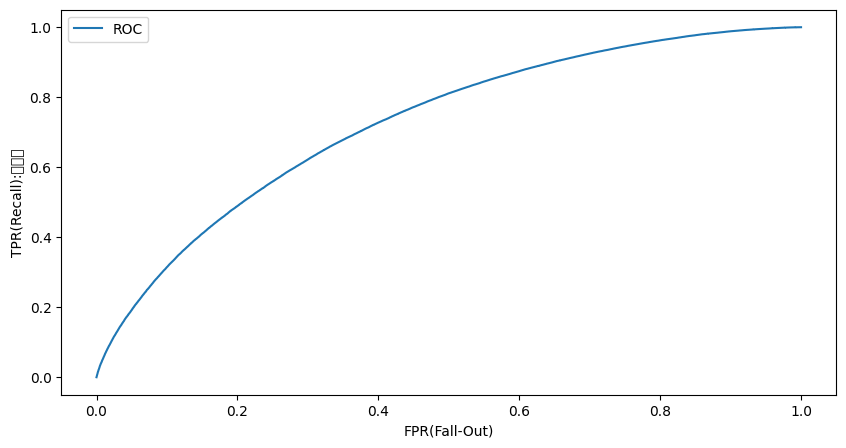

AUC: 0.7258068530399364
11288/11288 [==============================] - 7s 631us/step


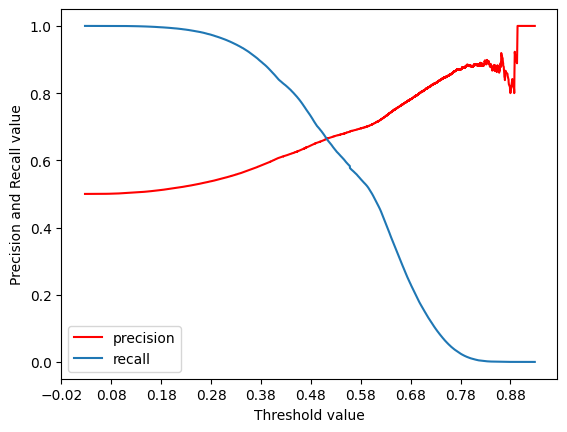

approximate optimal recall: 0.6640033222591362


<Figure size 640x480 with 0 Axes>

In [6]:
dnn_model = DNNModel()
dnn_model.load_file('data/final_train.csv')
dnn_model.scaling_data(StandardScaler, threshold=0.95, over_sampler=SMOTE)
input_dim = dnn_model.get_input_dim()
grid_params = {
    'batch_size': [100, 200, 400], 
    'epochs': [5], 
    'loss': ['binary_crossentropy'], 
    'num_layers': [3], 
    'num_nodes': [input_dim//2, input_dim*3//4, input_dim]}
best_params, _ = dnn_model.searching_best_param_grid(grid_params=grid_params)
# best_params = {'batch_size': 10000, 'epochs': 5, 'loss': 'binary_crossentropy', 'num_layers': 3, 'num_nodes': input_dim*2//3}
metric_result_dictionary = dnn_model.build_model_with_best_params(best_params=best_params, threshold=0.5)
print(f'AUC: {dnn_model.get_roc_auc_score()}')
model_name = dnn_model.get_model_name()
print(f'approximate optimal recall: {dnn_model.draw_precision_recall_curve_plot(min_delta=0.0001)}')
dnn_model.save_model()

====Data set resampled(oversampled)_SMOTE
==label ratio
True Label:	0.5
False Label:	0.5
Epoch 1/5
11559/11559 [==============================] - 13s 1ms/step - loss: 0.6488 - accuracy: 0.6237
Epoch 2/5
9030/9030 [==============================] - 6s 648us/step
Epoch 1/5
11559/11559 [==============================] - 12s 1ms/step - loss: 0.6435 - accuracy: 0.6288
Epoch 2/5
9030/9030 [==============================] - 6s 619us/step
Epoch 1/5
11559/11559 [==============================] - 12s 987us/step - loss: 0.6424 - accuracy: 0.6334
Epoch 2/5
9030/9030 [==============================] - 6s 605us/step
Epoch 1/5
11559/11559 [==============================] - 12s 968us/step - loss: 0.6478 - accuracy: 0.6278
Epoch 2/5
9030/9030 [==============================] - 5s 595us/step
Epoch 1/5
11559/11559 [==============================] - 11s 948us/step - loss: 0.6436 - accuracy: 0.6307
Epoch 2/5
9030/9030 [==============================] - 6s 598us/step
Epoch 1/5
11559/11559 [=================

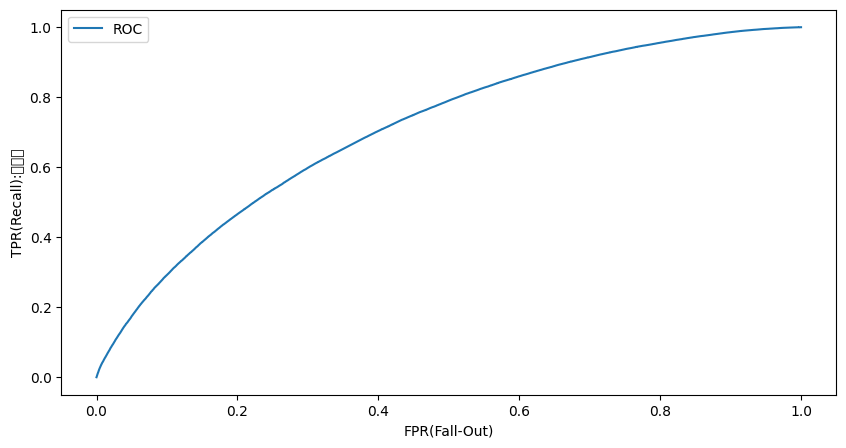

AUC: 0.7102864071810937
11288/11288 [==============================] - 7s 617us/step


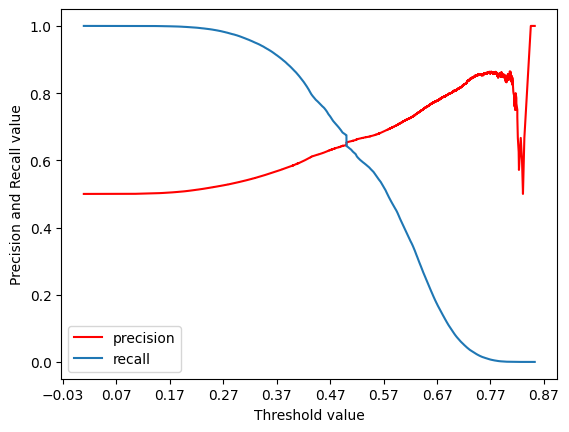

approximate optimal recall: [[1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.10741971e-05
  5.53709856e-06 0.00000000e+00]]


<Figure size 640x480 with 0 Axes>

In [7]:
dnn_model = DNNModel()
dnn_model.load_file('data/final_train.csv')
dnn_model.scaling_data(StandardScaler, threshold=0.7, over_sampler=SMOTE)
input_dim = dnn_model.get_input_dim()
grid_params = {
    'batch_size': [100, 200, 400], 
    'epochs': [5], 
    'loss': ['binary_crossentropy'], 
    'num_layers': [3], 
    'num_nodes': [input_dim//2, input_dim*3//4, input_dim]}
best_params, _ = dnn_model.searching_best_param_grid(grid_params=grid_params)
# best_params = {'batch_size': 10000, 'epochs': 5, 'loss': 'binary_crossentropy', 'num_layers': 3, 'num_nodes': input_dim*2//3}
metric_result_dictionary = dnn_model.build_model_with_best_params(best_params=best_params, threshold=0.5)
print(f'AUC: {dnn_model.get_roc_auc_score()}')
model_name = dnn_model.get_model_name()
print(f'approximate optimal recall: {dnn_model.draw_precision_recall_curve_plot(min_delta=0.0001)}')
dnn_model.save_model()